# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [371]:
# Deleting all model folders created from previous runs
!find . -type d -name "model*" -exec rm -rf {} +

In [155]:
import numpy as np
import os
import imageio.v2 as imageio
from skimage.transform import resize
import datetime
import matplotlib.pyplot as plt
import os

We set the random seed so that the results don't vary drastically.

In [156]:
!nvidia-smi

Mon Aug 21 13:20:03 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1070 Ti     On  | 00000000:01:00.0 Off |                  N/A |
|  0%   54C    P8              10W / 180W |   7636MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [157]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [158]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [159]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 16 #experiment with the batch size

In [160]:

def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [161]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zca_whitening = True
)

def generator(source_path, folder_list, batch_size, augment=False):
    total_frames = 30
    num_images = 20
    height = 120
    width = 120
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0,total_frames-1,num_images)).astype(int) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, num_images, height, width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width))
                    
                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size):
            remaining_batch_size = len(t)%batch_size
            batch_data   = np.zeros((remaining_batch_size, num_images, height, width,3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output           

            for folder in range(remaining_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)                          
                    
                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [163]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [164]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

## Models
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [243]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, GlobalAveragePooling2D, GlobalAveragePooling3D, ZeroPadding3D, BatchNormalization, Activation, Dropout, ConvLSTM2D
from keras.layers.convolutional import Conv2D, MaxPooling2D, Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

In [395]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}.h5' #-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [167]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

### Trial #1

Conv3D

In [168]:
#write your model here
input_shape = (20, 120, 120, 3)

model = Sequential()

model.add(Conv3D(32, (3,3,3), padding='same', activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, (3, 3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, (3, 3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(5))
model.add(Activation('softmax'))

In [169]:
optimiser = optimizers.Adam()#lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_39 (Conv3D)          (None, 20, 120, 120, 32)  2624      
                                                                 
 batch_normalization_43 (Bat  (None, 20, 120, 120, 32)  128      
 chNormalization)                                                
                                                                 
 max_pooling3d_35 (MaxPoolin  (None, 10, 60, 60, 32)   0         
 g3D)                                                            
                                                                 
 conv3d_40 (Conv3D)          (None, 10, 60, 60, 64)    55360     
                                                                 
 batch_normalization_44 (Bat  (None, 10, 60, 60, 64)   256       
 chNormalization)                                                
                                                     

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [170]:
history_model1 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_423004/1995094951.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_model1 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  ./Project_data/train ; batch size = 16
Epoch 1/10


2023-08-21 13:20:14.016922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-3.26492.h5
 1/42 [..............................] - ETA: 2:04 - loss: 3.2649 - categorical_accuracy: 0.1875
Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-19.85814.h5
 2/42 [>.............................] - ETA: 1:31 - loss: 19.8581 - categorical_accuracy: 0.2500
Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-26.93020.h5
 3/42 [=>............................] - ETA: 2:07 - loss: 26.9302 - categorical_accuracy: 0.2500
Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-22.02755.h5
 4/42 [=>............................] - ETA: 2:29 - loss: 22.0276 - categorical_accuracy: 0.3281
Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-18.90372.h5
 5/42 [==>...........................] - ETA: 2:25 - loss: 18.9037 - categorical_accuracy: 0.3125
Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-16.1698

2023-08-21 13:22:56.432855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


42/42 [==============================] - 187s 4s/step - loss: 4.9866 - categorical_accuracy: 0.4465 - val_loss: 4.8983 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/10

Epoch 2: saving model to model_init_2023-08-2113_20_04.277594/model-00002-0.82650.h5
 1/42 [..............................] - ETA: 15s - loss: 0.8265 - categorical_accuracy: 0.7500
Epoch 2: saving model to model_init_2023-08-2113_20_04.277594/model-00002-0.85650.h5
 2/42 [>.............................] - ETA: 2:04 - loss: 0.8565 - categorical_accuracy: 0.6562
Epoch 2: saving model to model_init_2023-08-2113_20_04.277594/model-00002-0.91237.h5
 3/42 [=>............................] - ETA: 2:09 - loss: 0.9124 - categorical_accuracy: 0.6875
Epoch 2: saving model to model_init_2023-08-2113_20_04.277594/model-00002-0.98767.h5
 4/42 [=>............................] - ETA: 1:51 - loss: 0.9877 - categorical_accuracy: 0.6719
Epoch 2: saving model to model_init_2023-08-2113_20_04.277594/model-00002-1.04444.h5
 5/42 [==

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


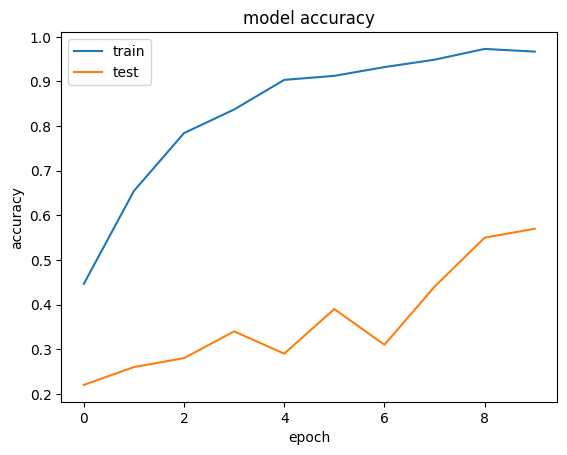

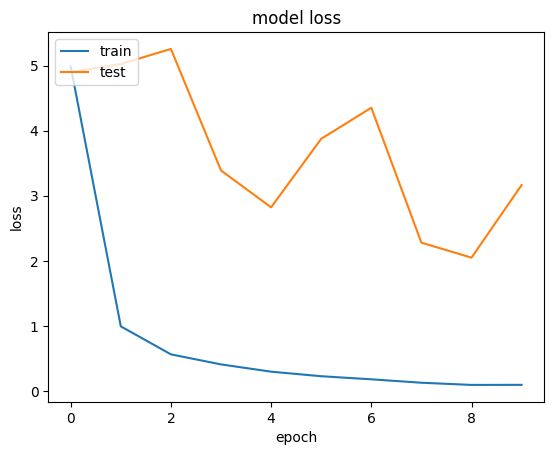

In [171]:
plot_loss_accuracy(history_model1)

### Trial #2

Conv2D + TimeDristributed + GRU

In [175]:
input_shape = (20, 120, 120, 3)

model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())

model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())

model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())

model.add(GRU(128))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

optimiser = optimizers.Adam()#lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 118, 118, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 59, 59, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization_55 (Bat  (None, 20, 59, 59, 32)   128       
 chNormalization)                                                
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 57, 57, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 28, 28, 64) 

2023-08-21 14:00:17.891091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-21 14:00:17.893075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-21 14:00:17.894680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [176]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_423004/3383535347.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/10


2023-08-21 14:00:24.876339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-08-21 14:00:25.442387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-21 14:00:25.443563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra


Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-2.47245.h5
 1/42 [..............................] - ETA: 4:45 - loss: 2.4725 - categorical_accuracy: 0.1250
Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-2.17593.h5
 2/42 [>.............................] - ETA: 9s - loss: 2.1759 - categorical_accuracy: 0.2188  
Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-1.95800.h5
 3/42 [=>............................] - ETA: 47s - loss: 1.9580 - categorical_accuracy: 0.2500
Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-1.78464.h5
 4/42 [=>............................] - ETA: 59s - loss: 1.7846 - categorical_accuracy: 0.3125
Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-1.73791.h5
 5/42 [==>...........................] - ETA: 1:01 - loss: 1.7379 - categorical_accuracy: 0.3375
Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-1.71100.h5
 6/42 

2023-08-21 14:02:02.454545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-08-21 14:02:02.682947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-21 14:02:02.684629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

42/42 [==============================] - 112s 3s/step - loss: 1.3664 - categorical_accuracy: 0.4359 - val_loss: 1.6009 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/10

Epoch 2: saving model to model_init_2023-08-2113_20_04.277594/model-00002-1.16044.h5
 1/42 [..............................] - ETA: 8s - loss: 1.1604 - categorical_accuracy: 0.5625
Epoch 2: saving model to model_init_2023-08-2113_20_04.277594/model-00002-1.09645.h5
 2/42 [>.............................] - ETA: 1:16 - loss: 1.0964 - categorical_accuracy: 0.5000
Epoch 2: saving model to model_init_2023-08-2113_20_04.277594/model-00002-1.16208.h5
 3/42 [=>............................] - ETA: 1:17 - loss: 1.1621 - categorical_accuracy: 0.5208
Epoch 2: saving model to model_init_2023-08-2113_20_04.277594/model-00002-1.18732.h5
 4/42 [=>............................] - ETA: 1:20 - loss: 1.1873 - categorical_accuracy: 0.5156
Epoch 2: saving model to model_init_2023-08-2113_20_04.277594/model-00002-1.16389.h5
 5/42 [==>

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


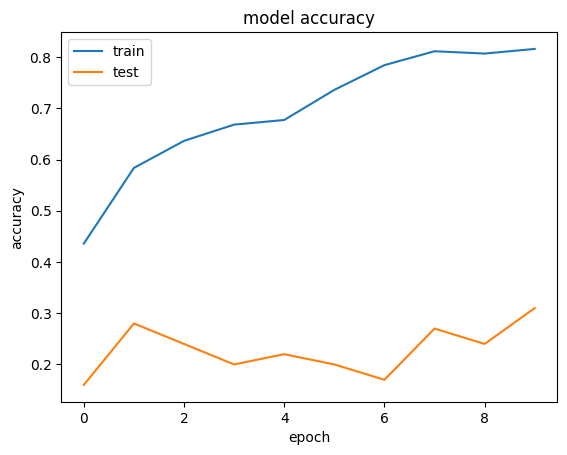

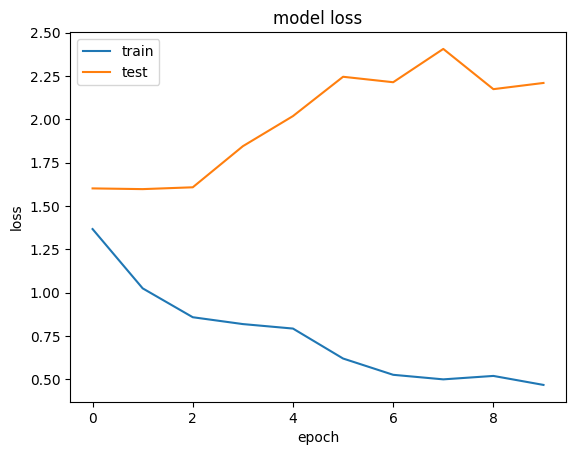

In [177]:
plot_loss_accuracy(history)

### Trial #3

Conv2D + TimeDistributed + GlobalAveragePooling2D

In [178]:
model = Sequential()

model.add(TimeDistributed(Conv2D(8, (3,3), activation='relu'), input_shape=input_shape))
model.add(BatchNormalization())

model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu')))
model.add(BatchNormalization())

model.add(ConvLSTM2D(8, kernel_size = 3, return_sequences=False))
model.add(BatchNormalization())

model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())

model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

optimiser = optimizers.Adam()#lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 20, 118, 118, 8)  224       
 tributed)                                                       
                                                                 
 batch_normalization_59 (Bat  (None, 20, 118, 118, 8)  32        
 chNormalization)                                                
                                                                 
 time_distributed_7 (TimeDis  (None, 20, 116, 116, 16)  1168     
 tributed)                                                       
                                                                 
 batch_normalization_60 (Bat  (None, 20, 116, 116, 16)  64       
 chNormalization)                                                
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 114, 114, 8)     

In [179]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_423004/3383535347.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/10


2023-08-21 14:20:32.605091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-1.60321.h5
 1/42 [..............................] - ETA: 2:42 - loss: 1.6032 - categorical_accuracy: 0.1875
Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-1.62506.h5
 2/42 [>.............................] - ETA: 31s - loss: 1.6251 - categorical_accuracy: 0.1875 
Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-1.60644.h5
 3/42 [=>............................] - ETA: 52s - loss: 1.6064 - categorical_accuracy: 0.2083
Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-1.59835.h5
 4/42 [=>............................] - ETA: 57s - loss: 1.5983 - categorical_accuracy: 0.2188
Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-1.58821.h5
 5/42 [==>...........................] - ETA: 59s - loss: 1.5882 - categorical_accuracy: 0.2750
Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-1.59391.h5
 6/42 [

2023-08-21 14:21:50.204177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


42/42 [==============================] - 90s 2s/step - loss: 1.4206 - categorical_accuracy: 0.4133 - val_loss: 1.6015 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/10

Epoch 2: saving model to model_init_2023-08-2113_20_04.277594/model-00002-1.20067.h5
 1/42 [..............................] - ETA: 20s - loss: 1.2007 - categorical_accuracy: 0.5000
Epoch 2: saving model to model_init_2023-08-2113_20_04.277594/model-00002-1.18538.h5
 2/42 [>.............................] - ETA: 1:14 - loss: 1.1854 - categorical_accuracy: 0.5938
Epoch 2: saving model to model_init_2023-08-2113_20_04.277594/model-00002-1.20866.h5
 3/42 [=>............................] - ETA: 1:10 - loss: 1.2087 - categorical_accuracy: 0.5417
Epoch 2: saving model to model_init_2023-08-2113_20_04.277594/model-00002-1.19252.h5
 4/42 [=>............................] - ETA: 1:10 - loss: 1.1925 - categorical_accuracy: 0.5625
Epoch 2: saving model to model_init_2023-08-2113_20_04.277594/model-00002-1.20285.h5
 5/42 [==>

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


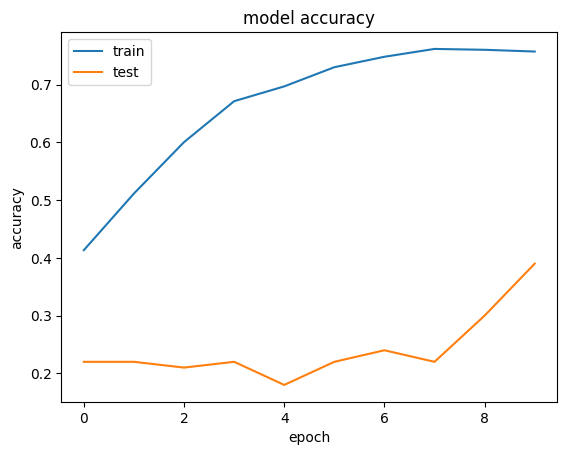

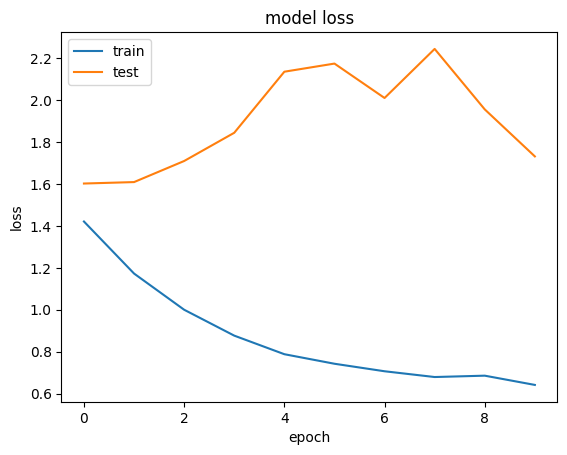

In [180]:
plot_loss_accuracy(history)

### Trial #4:

Conv3D + LSTM

In [323]:
from keras.layers import ConvLSTM3D, Bidirectional, LSTM, Reshape
from keras.models import Sequential

In [353]:
input_shape = (20, 120, 120, 3)

model = Sequential()

model.add(Conv3D(32, (3, 3, 3), input_shape=input_shape, activation='relu', padding='valid'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(64, (3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(128, (3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(BatchNormalization())

shape = model.layers[-1].output_shape
model.add(Reshape((shape[-1],shape[1]*shape[2]*shape[3])))

model.add(LSTM(32, return_sequences=True))
model.add(Dropout(.5))

model.add((Flatten()))

model.add(Dense(512, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(.5))

model.add(Dense(5, activation='softmax'))

2023-08-24 01:13:41.607482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-24 01:13:41.610884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-24 01:13:41.613720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [354]:
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_131"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_290 (Conv3D)         (None, 18, 118, 118, 32)  2624      
                                                                 
 max_pooling3d_209 (MaxPooli  (None, 9, 59, 59, 32)    0         
 ng3D)                                                           
                                                                 
 batch_normalization_231 (Ba  (None, 9, 59, 59, 32)    128       
 tchNormalization)                                               
                                                                 
 conv3d_291 (Conv3D)         (None, 7, 57, 57, 64)     55360     
                                                                 
 max_pooling3d_210 (MaxPooli  (None, 3, 28, 28, 64)    0         
 ng3D)                                                           
                                                    

In [355]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_423004/3383535347.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/10


2023-08-24 01:13:52.472932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-08-24 01:13:52.973116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-24 01:13:52.976968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra


Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-1.72935.h5
 1/42 [..............................] - ETA: 3:29 - loss: 1.7293 - categorical_accuracy: 0.1875
Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-1.73463.h5
 2/42 [>.............................] - ETA: 1:44 - loss: 1.7346 - categorical_accuracy: 0.2188
Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-1.80710.h5
 3/42 [=>............................] - ETA: 2:28 - loss: 1.8071 - categorical_accuracy: 0.1667
Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-1.79215.h5
 4/42 [=>............................] - ETA: 2:28 - loss: 1.7922 - categorical_accuracy: 0.1719
Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-1.77264.h5
 5/42 [==>...........................] - ETA: 2:13 - loss: 1.7726 - categorical_accuracy: 0.1690
Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-1.77729.h5
 6/4

2023-08-24 01:16:52.753732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-08-24 01:16:53.262489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-24 01:16:53.264621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

42/42 [==============================] - 222s 5s/step - loss: 1.4105 - categorical_accuracy: 0.3650 - val_loss: 1.5078 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/10

Epoch 2: saving model to model_init_2023-08-2113_20_04.277594/model-00002-1.28812.h5
 1/42 [..............................] - ETA: 27s - loss: 1.2881 - categorical_accuracy: 0.5000
Epoch 2: saving model to model_init_2023-08-2113_20_04.277594/model-00002-1.25146.h5
 2/42 [>.............................] - ETA: 3:02 - loss: 1.2515 - categorical_accuracy: 0.5000
Epoch 2: saving model to model_init_2023-08-2113_20_04.277594/model-00002-1.25229.h5
 3/42 [=>............................] - ETA: 2:51 - loss: 1.2523 - categorical_accuracy: 0.4583
Epoch 2: saving model to model_init_2023-08-2113_20_04.277594/model-00002-1.16429.h5
 4/42 [=>............................] - ETA: 2:51 - loss: 1.1643 - categorical_accuracy: 0.4688
Epoch 2: saving model to model_init_2023-08-2113_20_04.277594/model-00002-1.10450.h5
 5/42 [==

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


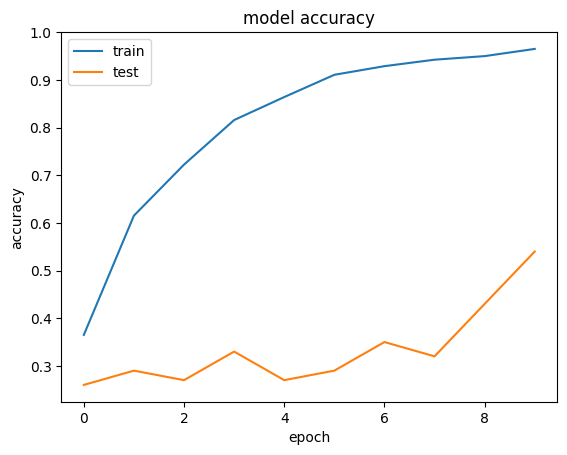

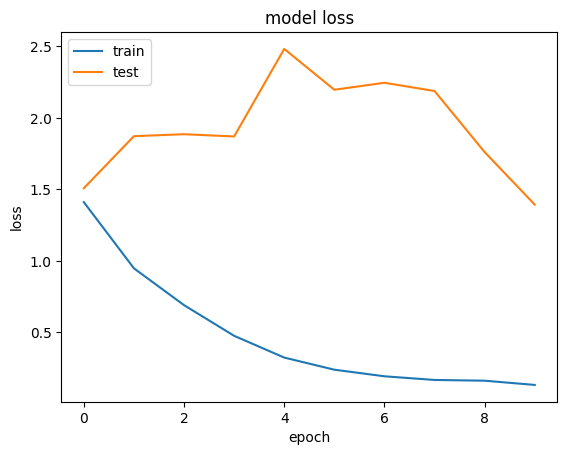

In [356]:
plot_loss_accuracy(history)

### Trial #5

Conv3D 4 layers, Dense 2 layers with 256 and 128 and 25% dropout

In [373]:
model = Sequential()

model.add(Conv3D(8, (3, 3, 3), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(16, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
 
model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
model.add(Conv3D(64, (3, 3, 3), padding='same'))    
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5))
model.add(Activation('softmax'))

In [374]:
optimiser = optimizers.Adam()
model.compile(optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_137"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_313 (Conv3D)         (None, 20, 120, 120, 8)   656       
                                                                 
 activation_91 (Activation)  (None, 20, 120, 120, 8)   0         
                                                                 
 batch_normalization_261 (Ba  (None, 20, 120, 120, 8)  32        
 tchNormalization)                                               
                                                                 
 max_pooling3d_232 (MaxPooli  (None, 10, 60, 60, 8)    0         
 ng3D)                                                           
                                                                 
 conv3d_314 (Conv3D)         (None, 10, 60, 60, 16)    3472      
                                                                 
 activation_92 (Activation)  (None, 10, 60, 60, 16) 

In [396]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [397]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_423004/2794917941.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/10

Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-1.42008-0.50000.h5


2023-08-24 02:26:04.643535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


 1/42 [..............................] - ETA: 9s - loss: 1.4201 - categorical_accuracy: 0.5000
Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-1.34737-0.50000.h5
 2/42 [>.............................] - ETA: 1:24 - loss: 1.3474 - categorical_accuracy: 0.5000
Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-1.60328-0.43750.h5
 3/42 [=>............................] - ETA: 1:26 - loss: 1.6033 - categorical_accuracy: 0.4375
Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-1.53923-0.43750.h5
 4/42 [=>............................] - ETA: 1:23 - loss: 1.5392 - categorical_accuracy: 0.4375
Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-1.53287-0.45000.h5
 5/42 [==>...........................] - ETA: 1:20 - loss: 1.5329 - categorical_accuracy: 0.4500
Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-1.52361-0.45833.h5
 6/42 [===>..........................] - ETA: 1:18 -

2023-08-24 02:27:34.429781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


42/42 [==============================] - 104s 3s/step - loss: 1.2104 - categorical_accuracy: 0.5732 - val_loss: 5.2581 - val_categorical_accuracy: 0.1100 - lr: 0.0010
Epoch 2/10

Epoch 2: saving model to model_init_2023-08-2113_20_04.277594/model-00002-0.87156-0.68750.h5
 1/42 [..............................] - ETA: 8s - loss: 0.8716 - categorical_accuracy: 0.6875
Epoch 2: saving model to model_init_2023-08-2113_20_04.277594/model-00002-0.74815-0.75000.h5
 2/42 [>.............................] - ETA: 1:33 - loss: 0.7482 - categorical_accuracy: 0.7500
Epoch 2: saving model to model_init_2023-08-2113_20_04.277594/model-00002-0.74197-0.72917.h5
 3/42 [=>............................] - ETA: 1:31 - loss: 0.7420 - categorical_accuracy: 0.7292
Epoch 2: saving model to model_init_2023-08-2113_20_04.277594/model-00002-0.80783-0.70312.h5
 4/42 [=>............................] - ETA: 1:25 - loss: 0.8078 - categorical_accuracy: 0.7031
Epoch 2: saving model to model_init_2023-08-2113_20_04.277594/m

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


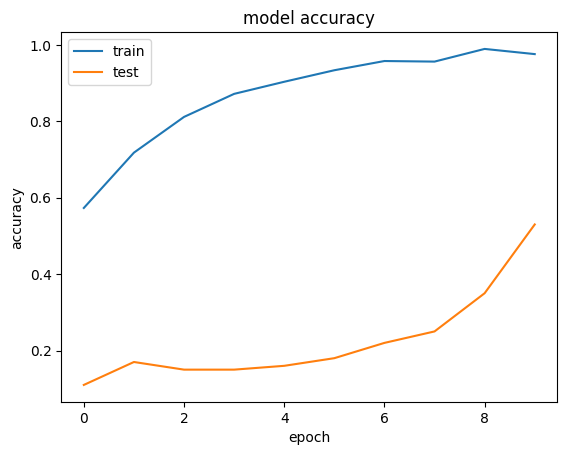

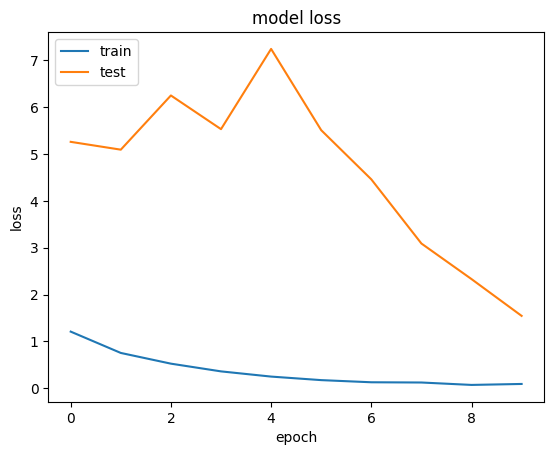

In [398]:
plot_loss_accuracy(history)

### Trial #6
Transfer Learning

In [401]:
from keras.applications import mobilenet

def mobilenet_RNN(fine_tune=False, gru=False, lstm_gru_cells=128, dense_nodes=128, dropout=0.25, num_images=20, height=120, width=120):

    mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
    print("Number of layers in the pretrained mobilenet model: ", len(mobilenet_transfer.layers))

    if (fine_tune):
        # Fine-tune from this layer onwards
        fine_tune_at = 50
        # Freeze all the layers before the `fine_tune_at` layer
        for layer in mobilenet_transfer.layers[:fine_tune_at]:
            layer.trainable = False

    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer,input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    if (gru):
        model.add(GRU(lstm_gru_cells))
    else:
        model.add(LSTM(lstm_gru_cells))
    model.add(Dropout(dropout))
    model.add(Dense(dense_nodes, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(5, activation='softmax'))

    opt = optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    return model

In [402]:
num_epochs = 20 
print ('# epochs =', num_epochs)
batch_size = 10
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(num_images=num_frames, gru=True)
print (model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 20
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_139"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_97 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_98 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_99 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_100 (TimeD  (None, 20, 1024)         0         
 istributed)                                                     
  

2023-08-24 02:49:39.720164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-24 02:49:39.721782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-24 02:49:39.723212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [403]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [404]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_423004/2794917941.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20


2023-08-24 02:50:50.827514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-08-24 02:50:51.598200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-24 02:50:51.599462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra


Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-1.94080-0.12500.h5
 1/67 [..............................] - ETA: 8:06 - loss: 1.9408 - categorical_accuracy: 0.1250
Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-1.84878-0.25000.h5
 2/67 [..............................] - ETA: 42s - loss: 1.8488 - categorical_accuracy: 0.2500 
Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-1.75682-0.27083.h5
 3/67 [>.............................] - ETA: 1:29 - loss: 1.7568 - categorical_accuracy: 0.2708
Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-1.67743-0.29688.h5
 4/67 [>.............................] - ETA: 1:37 - loss: 1.6774 - categorical_accuracy: 0.2969
Epoch 1: saving model to model_init_2023-08-2113_20_04.277594/model-00001-1.61432-0.32500.h5
 5/67 [=>............................] - ETA: 1:44 - loss: 1.6143 - categorical_accuracy: 0.3250
Epoch 1: saving model to model_init_2023-08-2113_

2023-08-24 02:53:25.318796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-08-24 02:53:25.857717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-24 02:53:25.859770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

67/67 [==============================] - 175s 3s/step - loss: 0.6006 - categorical_accuracy: 0.7676 - val_loss: 0.2456 - val_categorical_accuracy: 0.9265 - lr: 0.0010
Epoch 2/20

Epoch 2: saving model to model_init_2023-08-2113_20_04.277594/model-00002-0.18074-0.87500.h5
 1/67 [..............................] - ETA: 43s - loss: 0.1807 - categorical_accuracy: 0.8750
Epoch 2: saving model to model_init_2023-08-2113_20_04.277594/model-00002-0.11535-0.93750.h5
 2/67 [..............................] - ETA: 2:35 - loss: 0.1154 - categorical_accuracy: 0.9375
Epoch 2: saving model to model_init_2023-08-2113_20_04.277594/model-00002-0.10313-0.95833.h5
 3/67 [>.............................] - ETA: 2:30 - loss: 0.1031 - categorical_accuracy: 0.9583
Epoch 2: saving model to model_init_2023-08-2113_20_04.277594/model-00002-0.08353-0.96875.h5
 4/67 [>.............................] - ETA: 2:23 - loss: 0.0835 - categorical_accuracy: 0.9688
Epoch 2: saving model to model_init_2023-08-2113_20_04.277594/

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


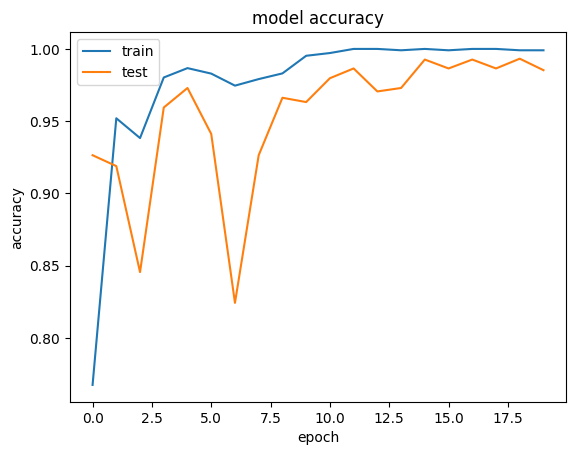

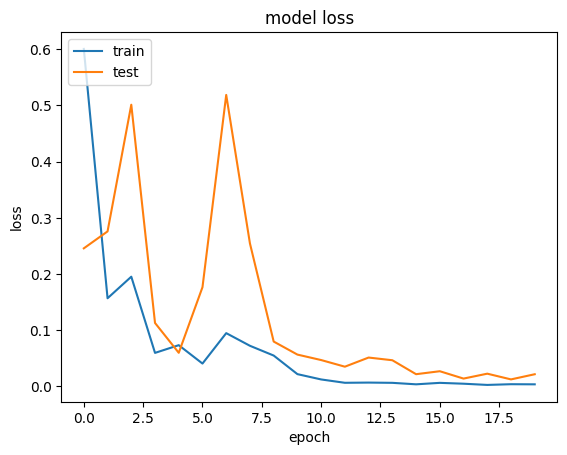

In [406]:
plot_loss_accuracy(history)

## Observations

Experiment | Model Config | Categorical Accuracy | Validation Accuracy
-----:|:-------------------------: | :---------------: | :---------------
1 | Conv3D (3 layers) | 96.68% | 57.00%
2 | Conv2D + TimeDistributed + GRU | 81.60% | 31.00%
3 | Conv2D + TimeDistributed + GlobalAveragePooling2D | 75.72% | 39.00%
4 | Conv3D + LSTM | 96.53% | 54.00%
5 | Conv3D (4 layers) | 97.59% | 53.00%
6 | Transfer Learning (MobileNet) + TimeDistributed + LSTM + GRU |  99.91% | 98.53%